<a href="https://colab.research.google.com/github/MarvinLok/Algo-Trading/blob/main/Pair_Trading_Cointegration_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
!pip install yfinance
import yfinance as yf
!pip install mplfinance
import mplfinance as mpf
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.5 MB/s eta 0:00:00


In [2]:
# Check for cointegration
def stationarity(data, cutoff=0.05):
    if adfuller(data, maxlag=1)[1] < cutoff:
        print('The series is stationary')
        print('p-value = ', adfuller(data, maxlag=1)[1])
    else:
        print('The series is NOT stationary')
        print('p-value = ', adfuller(data, maxlag=1)[1])

[*********************100%***********************]  2 of 2 completed


Text(0.5, 1.0, 'SHEL and BP Closing Prices')

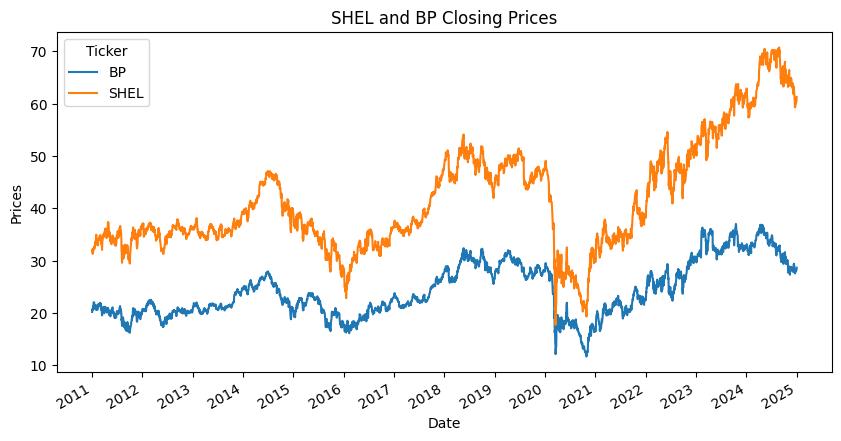

In [3]:
pairs = ['SHEL', 'BP']
data = yf.download(pairs, start="2011-01-01", end="2025-01-01",interval="1d",auto_adjust=True,multi_level_index=False)['Close']
fig, ax = plt.subplots(figsize=(10, 5))
data.plot(ax=ax)
ax.xaxis.set_major_locator(mdates.YearLocator())  # Set ticks at the start of each year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as year (e.g., 2011, 2012, ...)
plt.ylabel('Prices')
plt.xlabel('Date')
plt.title('SHEL and BP Closing Prices')

In [4]:
# Calculate daily returns for each asset
data['return_A'] = data['SHEL'].pct_change()
data['return_B'] = data['BP'].pct_change()

In [5]:
train_close, test_close = train_test_split(data, test_size=0.3, shuffle=False)

In [6]:
# Run OLS regression
model= sm.OLS(train_close['SHEL'],train_close['BP']).fit()
hedge_ratio = model.params[0]
print('Hedge Ratio = ', hedge_ratio)

Hedge Ratio =  1.6668515228979435


/tmp/ipython-input-3118805498.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]


In [7]:
train_spread = train_close['SHEL'] - model.params[0] * train_close['BP']

/tmp/ipython-input-2888320961.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_spread = train_close['SHEL'] - model.params[0] * train_close['BP']


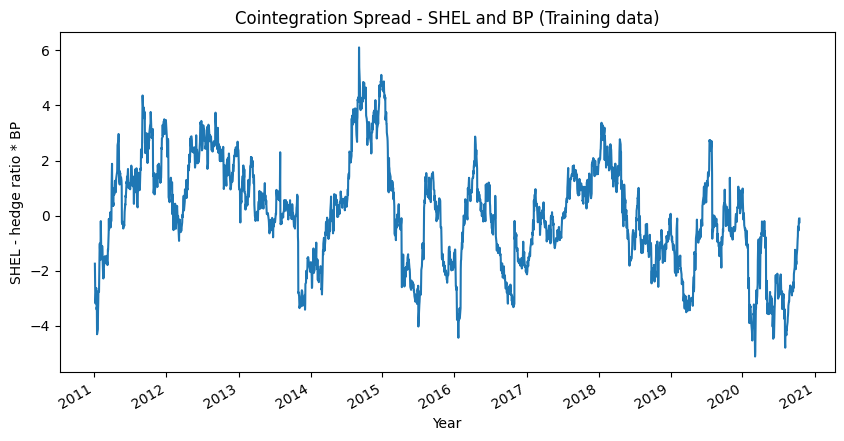

In [8]:
train_spread.plot(figsize=(10,5))
plt.ylabel('SHEL - hedge ratio * BP')
plt.xlabel('Year')
plt.title('Cointegration Spread - SHEL and BP (Training data)' )
plt.show()

In [9]:
stationarity(train_spread)

The series is stationary
p-value =  0.0005776979075984405


/tmp/ipython-input-1867928815.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_close['spread'] = train_close['SHEL'] - model.params[0] * train_close['BP']


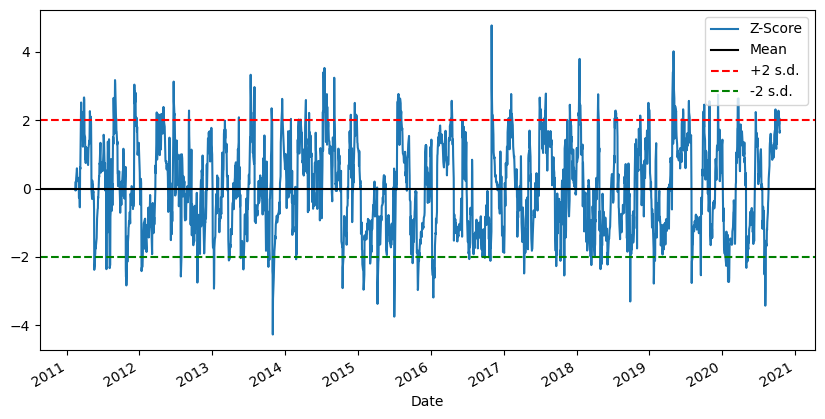

In [10]:
train_close['spread'] = train_close['SHEL'] - model.params[0] * train_close['BP']

# Compute rolling mean of ratio
window_length = 30
train_close['mavg_30'] = train_close.spread.rolling(window=window_length).mean()

# Compute rolling standard deviation of ratio
train_close['std_30'] = train_close.spread.rolling(window=window_length).std()

# Calculate z-score based on rolling window
train_close['z_score'] = (train_close.spread - train_close.mavg_30)/train_close.std_30

# Plot z-score
plt.figure(figsize=(10, 5))
train_close.z_score.plot()
plt.axhline(0, color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Z-Score', 'Mean', '+2 s.d.', '-2 s.d.'])
plt.show()

In [11]:
train_close['position_A'] = 0
train_close['position_B'] = 0

In [12]:
in_position = None
threshold = 2
total_trades = 0

# Loop through data to set positions
for i in range(1, len(train_close)):
    z = train_close['z_score'].iloc[i]

    if in_position is None:
        if z < -threshold:
            in_position = 'long'
            total_trades += 1
        elif z > threshold:
            in_position = 'short'
            total_trades += 1
    elif in_position == 'long':
        if z >= 0:
            in_position = None
    elif in_position == 'short':
        if z <= 0:
            in_position = None

    # Set positions using loc
    if in_position == 'long':
        train_close.loc[train_close.index[i], 'position_A'] = 1           # Long A
        train_close.loc[train_close.index[i], 'position_B'] = -hedge_ratio # Short B
    elif in_position == 'short':
        train_close.loc[train_close.index[i], 'position_A'] = -1          # Short A
        train_close.loc[train_close.index[i], 'position_B'] = hedge_ratio # Long B
    else:
        train_close.loc[train_close.index[i], 'position_A'] = 0
        train_close.loc[train_close.index[i], 'position_B'] = 0

/tmp/ipython-input-4227024582.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.6668515228979435' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_close.loc[train_close.index[i], 'position_B'] = hedge_ratio # Long B


In [13]:
# Calculate strategy daily return
# Shift positions by 1 to use previous day's position for today's return
train_close['strategy_daily_return'] = (train_close['position_A'].shift(1) * train_close['return_A'] + train_close['position_B'].shift(1) * train_close['return_B'])

# Calculate cumulative return (equity curve)
train_close['equity_curve'] = (1 + train_close['strategy_daily_return']).cumprod()

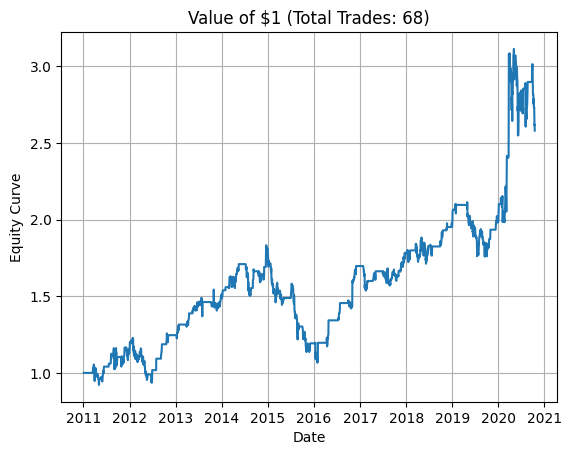

In [14]:
# Plot the equity curve
plt.plot(train_close['equity_curve'])
plt.title('Value of $1')
plt.title(f'Value of $1 (Total Trades: {total_trades})')
plt.xlabel('Date')
plt.ylabel('Equity Curve')
plt.grid(True)
plt.show()

Out-of-Sample Test

In [15]:
test_spread = test_close['SHEL'] - model.params[0] * test_close['BP']

/tmp/ipython-input-3282011838.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_spread = test_close['SHEL'] - model.params[0] * test_close['BP']


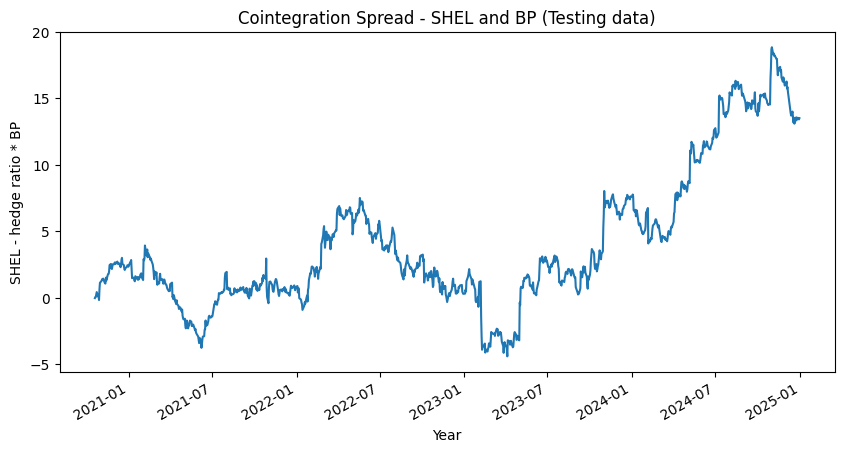

In [16]:
test_spread.plot(figsize=(10,5))
plt.ylabel('SHEL - hedge ratio * BP')
plt.xlabel('Year')
plt.title('Cointegration Spread - SHEL and BP (Testing data)' )
plt.show()

In [17]:
stationarity(test_spread)

The series is NOT stationary
p-value =  0.8073027938184809


In [18]:
# Run OLS regression
model= sm.OLS(test_close['SHEL'],test_close['BP']).fit()
hedge_ratio = model.params[0]
print('Hedge Ratio = ', hedge_ratio)

Hedge Ratio =  1.8161792780816977


/tmp/ipython-input-60378867.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[0]
